## Importing necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
import os
from sklearn.feature_selection import SelectKBest, f_regression
import sklearn.preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")

## Acquiring data

In [2]:
def get_zillow_data(host = host, user = user, password = password):
    filename = 'zillow.csv'
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        db = 'zillow'
        df = pd.read_sql('SELECT taxamount, lotsizesquarefeet, yearbuilt, fips, taxvaluedollarcnt, calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt, propertylandusetypeid, transactiondate FROM properties_2017 JOIN predictions_2017 USING(id) WHERE  propertylandusetypeid IN (261, 262, 263, 273, 275, 276, 279) AND transactiondate >= \'2017-05-01\' AND transactiondate <= \'2017-08-31\'', f'mysql+pymysql://{user}:{password}@{host}/{db}')
        df.to_csv(filename, index = False)
        return df


In [3]:
zillow = get_zillow_data()

## Prepping the data

In [4]:
# Adding in the age of the home, dropping the features used to select the specific data, putting in county names,
# creating tax rate feature

zillow['age'] = 2021 - zillow.yearbuilt
zillow.drop(columns = ['propertylandusetypeid', 'transactiondate', 'yearbuilt'], inplace = True)
zillow.fips.replace({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'}, inplace = True)
zillow.rename(columns = {'fips': 'county'}, inplace = True)
zillow['tax_rate'] = round((zillow.taxamount / zillow.taxvaluedollarcnt) * 100, 2)

In [5]:
# Dropping nulls

zillow.dropna(inplace = True)

In [6]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30373 entries, 0 to 31208
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   taxamount                     30373 non-null  float64
 1   lotsizesquarefeet             30373 non-null  float64
 2   county                        30373 non-null  object 
 3   taxvaluedollarcnt             30373 non-null  float64
 4   calculatedfinishedsquarefeet  30373 non-null  float64
 5   bathroomcnt                   30373 non-null  float64
 6   bedroomcnt                    30373 non-null  float64
 7   age                           30373 non-null  float64
 8   tax_rate                      30373 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.3+ MB


In [7]:
# Getting rid of property value outliers

Q1 = zillow['taxvaluedollarcnt'].quantile(0.25)
Q3 = zillow['taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1

zillow[zillow.taxvaluedollarcnt > (Q3 + IQR)].count()

taxamount                       2748
lotsizesquarefeet               2748
county                          2748
taxvaluedollarcnt               2748
calculatedfinishedsquarefeet    2748
bathroomcnt                     2748
bedroomcnt                      2748
age                             2748
tax_rate                        2748
dtype: int64

In [8]:
zillow_no_out = zillow[(zillow.taxvaluedollarcnt < (Q3 + IQR)) & (zillow.taxvaluedollarcnt > (Q1 - IQR))]

In [9]:
# Getting rid of tax lot size outliers

Q1 = zillow_no_out['lotsizesquarefeet'].quantile(0.25)
Q3 = zillow_no_out['lotsizesquarefeet'].quantile(0.75)
IQR = Q3 - Q1

zillow_no_out[zillow_no_out.lotsizesquarefeet > (Q3 + IQR)].count()

taxamount                       3374
lotsizesquarefeet               3374
county                          3374
taxvaluedollarcnt               3374
calculatedfinishedsquarefeet    3374
bathroomcnt                     3374
bedroomcnt                      3374
age                             3374
tax_rate                        3374
dtype: int64

In [10]:
zillow_no_out = zillow_no_out[(zillow_no_out.lotsizesquarefeet < (Q3 + IQR)) & (zillow_no_out.lotsizesquarefeet > (Q1 - IQR))]

In [11]:
# Splitting into train, test, and validate

train, test = train_test_split(zillow_no_out, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

## Explore

In [12]:
train

,taxamount,lotsizesquarefeet,county,taxvaluedollarcnt,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,tax_rate
3272,823.63,7502.0,Los Angeles,45507.0,864.0,1.0,2.0,70.0,1.81
2899,4326.04,5849.0,Los Angeles,350697.0,1584.0,2.0,3.0,98.0,1.23
8542,1315.74,7200.0,Orange,132879.0,1309.0,2.0,3.0,49.0,0.99
20649,8671.24,5208.0,Los Angeles,663216.0,2978.0,3.0,5.0,17.0,1.31
9307,7463.74,8047.0,Orange,619056.0,2710.0,3.0,3.0,19.0,1.21
...,...,...,...,...,...,...,...,...,...
6982,5713.50,6240.0,Orange,479778.0,1434.0,2.0,4.0,58.0,1.19
11306,3190.23,7800.0,Los Angeles,262475.0,1158.0,1.0,3.0,75.0,1.22
4927,6637.67,7565.0,Los Angeles,579063.0,1819.0,2.0,3.0,67.0,1.15
31069,6234.64,7344.0,Orange,610266.0,1875.0,3.0,3.0,54.0,1.02


In [13]:
# Counts of each county

train.groupby('county').count()

,taxamount,lotsizesquarefeet,taxvaluedollarcnt,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,tax_rate
county,,,,,,,,
Los Angeles,9004,9004,9004,9004,9004,9004,9004,9004
Orange,3309,3309,3309,3309,3309,3309,3309,3309
Ventura,683,683,683,683,683,683,683,683


<AxesSubplot:>

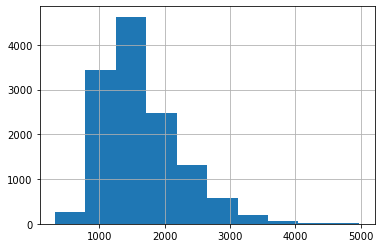

In [14]:
# Histogram of square foot breakdown

train.calculatedfinishedsquarefeet.hist()

<AxesSubplot:>

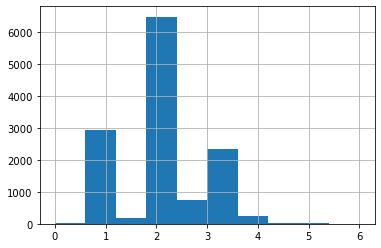

In [15]:
# Histogram of bathroom counts

train.bathroomcnt.hist()

<AxesSubplot:>

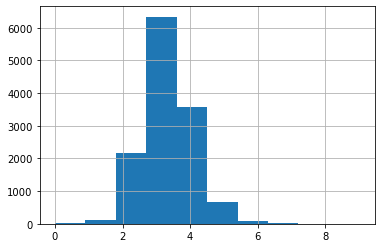

In [16]:
# Histogram of bedroom counts

train.bedroomcnt.hist()

<AxesSubplot:>

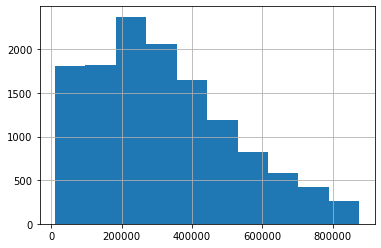

In [17]:
# Histogram of property values

train.taxvaluedollarcnt.hist()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

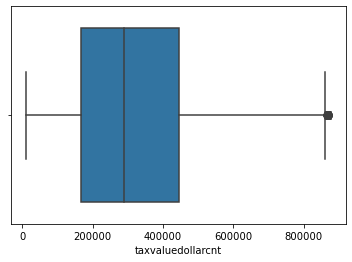

In [18]:
# Boxplot of property values

sns.boxplot(train.taxvaluedollarcnt)

<AxesSubplot:xlabel='bedroomcnt'>

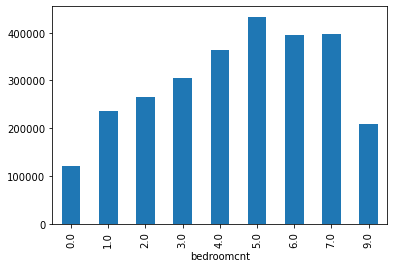

In [19]:
# Bar chart of bedroom counts

train.groupby('bedroomcnt').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='bathroomcnt'>

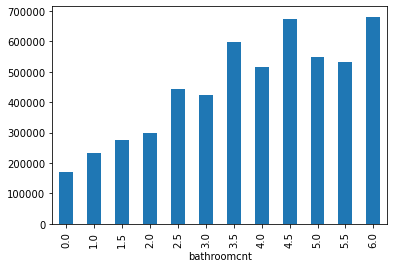

In [20]:
# Bar chart of bathroom counts

train.groupby('bathroomcnt').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='taxvaluedollarcnt'>

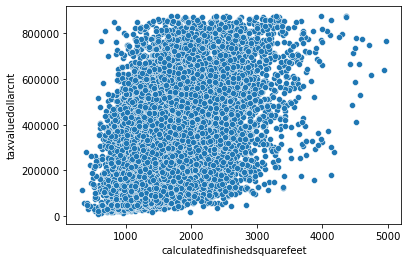

In [21]:
# Scatterplot of property square feet and property value

sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'taxvaluedollarcnt', data = train)

<AxesSubplot:xlabel='age', ylabel='taxvaluedollarcnt'>

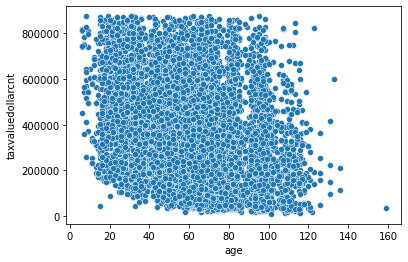

In [22]:
# Scatterplot of property age and property value

sns.scatterplot(x = 'age', y = 'taxvaluedollarcnt', data = train)

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='Count'>

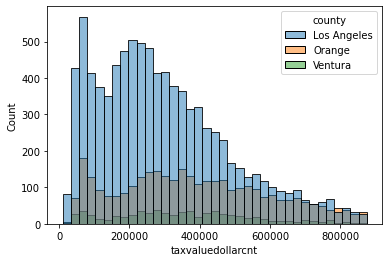

In [23]:
# Histogram of different counties property values

sns.histplot(data = train, x = "taxvaluedollarcnt", hue = "county")

<AxesSubplot:xlabel='county'>

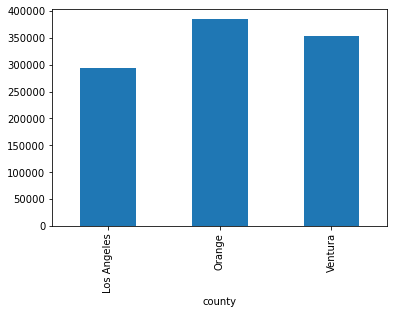

In [24]:
# Bar chart of average property value by county

train.groupby('county').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='county'>

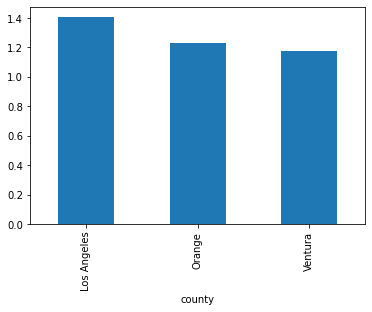

In [25]:
# Bar chart of average tax rate by county

train.groupby('county').tax_rate.mean().plot.bar()

In [26]:
# Splitting train data into subgroups by county

la_county = train[train['county'] == 'Los Angeles']
o_county = train[train['county'] == 'Orange']
vt_county = train[train['county'] == 'Ventura']
la_county.tax_rate.mean(), o_county.tax_rate.mean(), vt_county.tax_rate.mean()

(1.406812527765416, 1.2298035660320308, 1.1758711566617828)

In [27]:
# Making subgroups by county minus the outliers for visualization

Q1 = train['tax_rate'].quantile(0.25)
Q3 = train['tax_rate'].quantile(0.75)
IQR = Q3 - Q1
zillow_taxrates = train[(train.tax_rate < (Q3 + IQR)) & (train.tax_rate > (Q1 - IQR))]
la_county_tax = zillow_taxrates[zillow_taxrates['county'] == 'Los Angeles']
o_county_tax = zillow_taxrates[zillow_taxrates['county'] == 'Orange']
vt_county_tax = zillow_taxrates[zillow_taxrates['county'] == 'Ventura']

In [28]:
zillow_no_out[zillow_no_out.tax_rate > (Q3 + IQR)].count()

taxamount                       3093
lotsizesquarefeet               3093
county                          3093
taxvaluedollarcnt               3093
calculatedfinishedsquarefeet    3093
bathroomcnt                     3093
bedroomcnt                      3093
age                             3093
tax_rate                        3093
dtype: int64

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

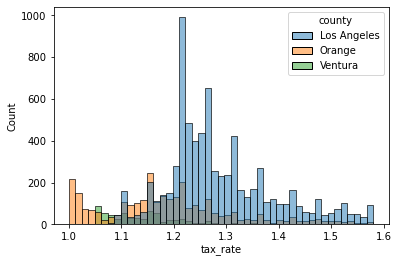

In [29]:
# Histogram of different counties tax rates

sns.histplot(data = zillow_taxrates, x = "tax_rate", hue = "county")

In [57]:
zillow_taxrates.count()

taxamount                       11117
lotsizesquarefeet               11117
county                          11117
taxvaluedollarcnt               11117
calculatedfinishedsquarefeet    11117
bathroomcnt                     11117
bedroomcnt                      11117
age                             11117
tax_rate                        11117
dtype: int64

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

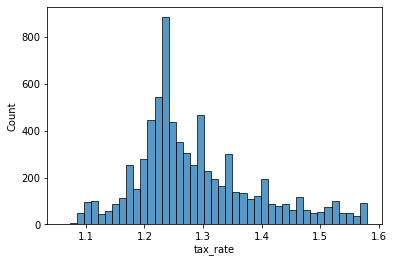

In [30]:
# Histogram of tax rates in Los Angeles county

sns.histplot(data = la_county_tax, x = "tax_rate")

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

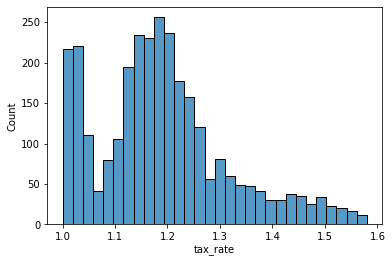

In [31]:
# Histogram of tax rates in Orange county

sns.histplot(data = o_county_tax, x = "tax_rate")

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

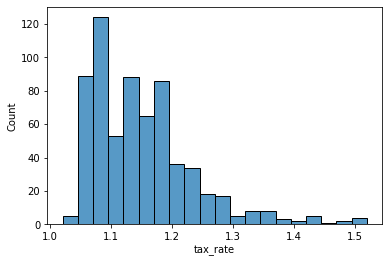

In [32]:
# Histogram of tax rates in Ventura county

sns.histplot(data = vt_county_tax, x = "tax_rate")

## Statistical tests

### Hypothesis 1

#### Null Hypothesis: There is no linear correlation between the square feet of a property and the tax value of that property

#### Alternative Hypothesis: There is a linear correlation between the square feet of a property and the tax value of that property

In [33]:
# Running a correlation test between property square feet and property value

corr, p = stats.pearsonr(train.taxvaluedollarcnt, train.calculatedfinishedsquarefeet)
corr, p

(0.43564309578325583, 0.0)

#### We reject the null hypothesis that there is no linear relationship between square feet of a property and the tax value of that property.

A bigger house correlating with a higher value doesn't come as much of a surprise.

### Hypothesis 2

#### Null Hypothesis: There is no difference between Los Angeles county tax rate and the overall average county tax rates

#### Alternative Hypothesis:  There is a difference between Los Angeles county tax rate and the overall average county tax rates

<AxesSubplot:xlabel='tax_rate', ylabel='Density'>

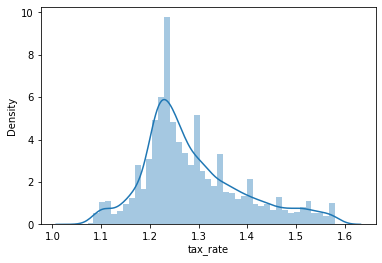

In [34]:
# Examining shape of LA county tax rates

sns.distplot(la_county_tax.tax_rate)

In [35]:
# Checking difference in median and mean tax rates

train.tax_rate.median(), train.tax_rate.mean()

(1.25, 1.3496060326254111)

In [36]:
# T-test between LA tax rate and average tax rate

t, p = stats.ttest_1samp(la_county.tax_rate, zillow_no_out.tax_rate.mean())
t, p

(13.024833428527987, 1.964452079950286e-38)

#### We reject the null hypothesis that there is no difference between Los Angeles county tax rate and the overall average county tax rates

As could have been guessed by the tax rate histogram, it seems the tax rate in Los Angeles is higher than the average tax rate.

## Modeling

### Prepping again for modeling

In [37]:
# Dropping columns related to property value (because that's cheating). Also creating dummies

zillow_no_out.drop(columns = ['tax_rate', 'taxamount'], inplace = True)
dummies_county = pd.get_dummies(zillow_no_out[['county']], drop_first = True)
zillow_no_out.drop(columns = ['county'], inplace = True)
zillow_no_out = pd.concat([zillow_no_out, dummies_county], axis=1)

In [38]:
# Scaling data so it can be modeled correctly

scaler_minmax = sklearn.preprocessing.MinMaxScaler()
scaler_minmax.fit(zillow_no_out)
zillow_minmax = scaler_minmax.transform(zillow_no_out)
zillow_minmax = pd.DataFrame(zillow_minmax)
key = zillow_no_out.columns.tolist()
zillow_minmax.rename(columns = {i: key[i] for i in range(len(key))} , inplace = True)
zillow_minmax.drop(columns = ['taxvaluedollarcnt'], inplace = True)
zillow_no_out.index = zillow_minmax.index
zillow_minmax['taxvaluedollarcnt'] = zillow['taxvaluedollarcnt']
zillow_minmax.dropna(inplace = True)

In [39]:
# Splitting into train, test, and validate

train, test = train_test_split(zillow_minmax, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

In [40]:
train.head()

,lotsizesquarefeet,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,county_Orange,county_Ventura,taxvaluedollarcnt
19681,0.407935,0.216007,0.142857,0.333333,0.418301,0.0,0.0,482772.0
2314,0.283248,0.196407,0.142857,0.222222,0.614379,0.0,0.0,365489.0
3859,0.411098,0.185586,0.142857,0.222222,0.431373,0.0,0.0,69677.0
8000,0.394886,0.366680,0.285714,0.333333,0.294118,0.0,0.0,798000.0
21426,0.652959,0.426296,0.428571,0.444444,0.333333,1.0,0.0,38374.0


In [41]:
x_train = train.drop(columns = ['taxvaluedollarcnt'])
y_train = train['taxvaluedollarcnt']

x_validate = validate.drop(columns = ['taxvaluedollarcnt'])
y_validate = validate['taxvaluedollarcnt']

x_test = test.drop(columns = ['taxvaluedollarcnt'])
y_test = test['taxvaluedollarcnt']

### Establishing a baseline

In [42]:
# Using average and median to predict property values to establish a baseline for my models

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Establishing mean
zillow_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['zillow_pred_mean'] = zillow_pred_mean
y_validate['zillow_pred_mean'] = zillow_pred_mean

# Establishing median
zillow_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['zillow_pred_median'] = zillow_pred_median
y_validate['zillow_pred_median'] = zillow_pred_median

# RMSE of mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.zillow_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.zillow_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.zillow_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.zillow_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  609536.68 
Validate/Out-of-Sample:  588634.66
RMSE using Median
Train/In-Sample:  623551.13 
Validate/Out-of-Sample:  602831.5


### Linear Regression

In [43]:
lin_reg = LinearRegression(normalize = True)
lin_reg.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_lm'] = lin_reg.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lm)**(1/2)
y_validate['value_pred_lm'] = lin_reg.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lm)**(1/2)
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for OLS using LinearRegression
Training/In-Sample:  608464.47 
Validation/Out-of-Sample:  587222.09


### LassoLars

In [44]:
lars = LassoLars(alpha=1.0)
lars.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_lars'] = lars.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lars)**(1/2)
y_validate['value_pred_lars'] = lars.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lars)**(1/2)
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Lasso + Lars
Training/In-Sample:  608464.57 
Validation/Out-of-Sample:  587222.7


### TweedieRegressor(GLM)

In [45]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_glm'] = glm.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_glm)**(1/2)
y_validate['value_pred_glm'] = glm.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_glm)**(1/2)
print("RMSE for Tweedie Regressor\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Tweedie Regressor
Training/In-Sample:  608465.3 
Validation/Out-of-Sample:  587254.69


### Polynomial Regression

In [46]:
pf = PolynomialFeatures(degree=2)
x_train_degree2 = pf.fit_transform(x_train)
x_validate_degree2 = pf.transform(x_validate)

In [47]:
lm2 = LinearRegression(normalize=True)
lm2.fit(x_train_degree2, y_train['taxvaluedollarcnt'])
y_train['value_pred_lm2'] = lm2.predict(x_train_degree2)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lm2)**(1/2)
y_validate['value_pred_lm2'] = lm2.predict(x_validate_degree2)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lm2)**(1/2)
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  607336.8 
Validation/Out-of-Sample:  587003.46


## Feature Engineering

### SelectKBest

In [48]:
f_selector = SelectKBest(f_regression, k=4)
f_selector.fit(zillow_minmax.drop(columns = ['taxvaluedollarcnt']), zillow_minmax['taxvaluedollarcnt'])
feature_mask = f_selector.get_support()
f_feature = zillow_minmax.drop(columns = ['taxvaluedollarcnt']).iloc[:,feature_mask].columns.tolist()
f_feature

['bathroomcnt', 'age', 'county_Orange', 'county_Ventura']

### Recursive Feature Elimination

In [49]:
lm = LinearRegression()
rfe = RFE(lm, 4)
rfe.fit(zillow_minmax.drop(columns = ['taxvaluedollarcnt']), zillow_minmax['taxvaluedollarcnt'])
feature_mask_rfe = rfe.support_
rfe_feature = zillow_minmax.drop(columns = ['taxvaluedollarcnt']).iloc[:,feature_mask_rfe].columns.tolist()
rfe_feature

['bathroomcnt', 'bedroomcnt', 'age', 'county_Ventura']

# Test

In [50]:
# Since Polynomial Regression was my most successful model at predicting out of sample data, I'm going to use that 
# model on my test data
x_test_degree2 = pf.transform(x_test)
y_test = pd.DataFrame(y_test)
y_test['test_value_pred_lm2'] = lm2.predict(x_test_degree2)
rmse_test = mean_squared_error(y_test['taxvaluedollarcnt'], y_test.test_value_pred_lm2)**(1/2)

print("RMSE for Tweedie Regressor\nTest: ", round(rmse_test, 2))

RMSE for Tweedie Regressor
Test:  591178.74


# Data Dictionary

In [51]:
data_dictionary = pd.DataFrame(index = zillow.columns, columns=['type', 'description'])
for name in zillow_no_out.columns:
    data_dictionary.loc[name,'type'] = 'float64'

In [52]:
data_dictionary.loc[['county'], 'type'] = 'object'

In [53]:
data_dictionary.loc[['taxamount'], 'description'] = 'The annual taxes charged for the property'
data_dictionary.loc[['lotsizesquarefeet'], 'description'] = 'The total square feet of the lot the property is on'
data_dictionary.loc[['county'], 'description'] = 'The county the property is located in'
data_dictionary.loc[['taxvaluedollarcnt'], 'description'] = 'The total tax assessed value of the property'
data_dictionary.loc[['calculatedfinishedsquarefeet'], 'description'] = 'The total square feet of the developed property'
data_dictionary.loc[['bathroomcnt'], 'description'] = 'The number of bathrooms in the property'
data_dictionary.loc[['bedroomcnt'], 'description'] = 'The number of bedrroms in the property'
data_dictionary.loc[['age'], 'description'] = 'The age of the developed property'
data_dictionary.loc[['tax_rate'], 'description'] = 'The percentage of annual taxes to total tax assessed value of the property'

In [54]:
print(data_dictionary.to_markdown())

|                              | type    | description                                                                |
|:-----------------------------|:--------|:---------------------------------------------------------------------------|
| taxamount                    | nan     | The annual taxes charged for the property                                  |
| lotsizesquarefeet            | float64 | The total square feet of the lot the property is on                        |
| county                       | object  | The county the property is located in                                      |
| taxvaluedollarcnt            | float64 | The total tax assessed value of the property                               |
| calculatedfinishedsquarefeet | float64 | The total square feet of the developed property                            |
| bathroomcnt                  | float64 | The number of bathrooms in the property                                    |
| bedroomcnt                   | float64

In [55]:
#Q1 = zillow_no_out['tax_rate'].quantile(0.25)
#Q3 = zillow_no_out['tax_rate'].quantile(0.75)
#IQR = Q3 - Q1
#zillow_no_out = zillow_no_out[(zillow_no_out.tax_rate < (Q3 + IQR)) & (zillow_no_out.tax_rate > (Q1 - IQR))]